# Introduction 简介

**Author: M. Ravasi, KAUST**

Welcome to the **Matrix-free inverse problems with PyLops** tutorial!

The aim of this tutorial is to:

- Introduce you to the concept of *linear operators* and their usage in the solution of *inverse problems*;
- Show how PyLops can be used to set-up non-trivial linear operators and solve inverse problems in Python; 
- Walk you through a set of use cases where PyLops has been leveraged to solve real scientific problems and discuss future directions of development.

欢迎来到 **使用 PyLops 解决无矩阵逆问题** 教程！

本教程旨在：

- 向您介绍 *线性算子* 的概念及其在 *逆问题* 求解中的用法；
- 展示如何使用 PyLops 设置非平凡的线性算子并在 Python 中解决逆问题；
- 带您了解一组用例，其中 PyLops 已被用于解决实际科学问题，并讨论未来的发展方向。

## Useful links 有用的链接

- Tutorial Github repository: https://github.com/PyLops/pylops_transform2021
        
- PyLops Github repository: https://github.com/PyLops/pylops

- PyLops reference documentation: https://pylops.readthedocs.io/en/latest/

## Theory in a nutshell 简明理论

In this tutorial we will try to keep the theory to a minimum and quickly expose you to practical examples. However, we want to make sure that some of the basic underlying concepts are clear to everyone and define a common mathematical notation.

在本教程中，我们将尽量减少理论内容，并快速向您展示实际示例。但是，我们要确保每个人都清楚一些基本的底层概念，并定义通用的数学符号。

At the core of PyLops lies the concept of **linear operators**. A linear operator is generally a mapping or function that acts linearly on elements of a space to produce elements of another space. More specifically we say that $\mathbf{A}:\mathbb{F}^m \to \mathbb{F}^n$ is a linear operator that maps a vector of size $m$ in the *model space* to a vector of size $n$ in the *data space*:

PyLops 的核心在于 **线性算子** 的概念。线性算子通常是一个映射或函数，它线性地作用于一个空间的元素以产生另一个空间的元素。更具体地说，我们说 $\mathbf{A}:\mathbb{F}^m \to \mathbb{F}^n$ 是一个线性算子，它将 *模型空间* 中大小为 $m$ 的向量映射到 *数据空间* 中大小为 $n$ 的向量：

<img src="figs/forward.png" width="300">

We will refer to this as **forward model (or operation)**. 

我们将此称为 **正演模型（或操作）**。

Conversely the application of its adjoint to a data vector is referred to as **adjoint modelling (or operation)**:

反之，将其伴随算子应用于数据向量被称为 **伴随建模（或操作）**：

<img src="figs/adjoint.png" width="300">

In its simplest form, a linear operator can be seen as a **matrix** of size $n \times m$ (and the adjoint is simply its transpose and complex conjugate). However in a more general sense we can think of a linear operator as any pair of software code that mimics the effect a matrix on a model vector as well as that of its adjoint to a data vector.

在其最简单的形式中，线性算子可以看作是一个大小为 $n \times m$ 的 **矩阵**（其伴随算子仅仅是其转置和复共轭）。然而，在更一般的意义上，我们可以将线性算子视为任何一对软件代码，它们模拟矩阵对模型向量的影响以及其伴随算子对数据向量的影响。

Solving an inverse problems accounts to removing the effect of the operator/matrix $\mathbf{A}$ from the data $\mathbf{y}$ to retrieve the model $\mathbf{x}$ (or an approximation of it).

解决逆问题相当于从数据 $\mathbf{y}$ 中去除算子/矩阵 $\mathbf{A}$ 的影响，以检索模型 $\mathbf{x}$（或其近似值）。

$$\hat{\mathbf{x}} = \mathbf{A}^{-1} \mathbf{y}$$

In practice, the inverse of $\mathbf{A}$ is generally not explicitely required. A solution can be obtained using either direct methods, matrix decompositions (eg SVD) or iterative solvers. Luckily, many iterative methods (e.g. cg, lsqr) do not need to know the individual entries of a matrix to solve a linear system. Such solvers only require the computation of forward and adjoint matrix-vector products - exactly what a linear operator does!

实际上，通常不需要显式地求 $\mathbf{A}$ 的逆。可以使用直接方法、矩阵分解（例如 SVD）或迭代求解器获得解。幸运的是，许多迭代方法（例如 cg, lsqr）不需要知道矩阵的各个条目即可求解线性系统。此类求解器只需要计算正演和伴随矩阵-向量乘积——这正是线性算子所做的！

**So what?**
We have learned that to solve an inverse problem, we do not need to express the modelling operator in terms of its dense (or sparse) matrix. All we need to know is how to perform the forward and adjoint operations - ideally as fast as possible and using the least amount of memory. 

**那又怎样？**
我们已经了解到，要解决逆问题，我们不需要用稠密（或稀疏）矩阵来表示建模算子。我们只需要知道如何执行正演和伴随操作——理想情况下尽可能快并使用最少的内存。

Our first task will be to understand how we can effectively write a linear operator on pen and paper and translate it into computer code. We will consider 2 examples:

我们的首要任务是了解如何在纸笔上有效地编写线性算子并将其转换为计算机代码。我们将考虑 2 个示例：

- Element-wise multiplication (also known as Hadamard product)
- First Derivative

- 逐元素乘法（也称为哈达玛积）
- 一阶导数

Let's first import the libraries we need in this tutorial.

首先让我们导入本教程所需的库。

In [2]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pympler scooby

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pylops
import scooby
from pylops import LinearOperator

# PyLops v2 fix: explicit import, snake_case function, new arg order (Op, y, Regs), and tuple unpacking
from pylops.optimization.leastsquares import normal_equations_inversion, preconditioned_inversion, regularized_inversion
from pylops.utils import dottest
from pylops.utils.wavelets import ricker
from scipy.linalg import lstsq
from scipy.signal import filtfilt


## Element-wise multiplication 逐元素乘法

We start by creating a barebore linear operator that performs a simple element-wise multiplication between two vectors (the so-called Hadamart product):

我们首先创建一个基本的线性算子，它执行两个向量之间的简单逐元素乘法（所谓的哈达玛积）：

$$ y_i = d_i x_i  \quad \forall i=0,1,...,n-1 $$

If we think about the forward problem the way we wrote it before, we can see that this operator can be equivalently expressed as a dot-product between a square matrix $\mathbf{D}$ that has the $d_i$ elements along its main diagonal and a vector $\mathbf{x}$:

如果我们按照之前的方式思考正演问题，我们可以看到该算子可以等效地表示为一个方阵 $\mathbf{D}$ 与向量 $\mathbf{x}$ 之间的点积，其中 $\mathbf{D}$ 的主对角线上有 $d_i$ 元素：

<img src="figs/diagonal.png" width="600">

Because of this, the related linear operator is called *Diagonal* operator in PyLops.

正因为如此，相关的线性算子在 PyLops 中被称为 *对角 (Diagonal)* 算子。

We are ready to implement this operator in 2 different ways:

我们准备用 2 种不同的方式实现此算子：

- directly as a diagonal matrix; 
- as a linear operator that performs directly element-wise multiplication.
- 直接作为对角矩阵；
- 作为一个直接执行逐元素乘法的线性算子。

### Dense matrix definition 定义稠密矩阵

In [4]:
n = 10
diag = np.arange(n)

D = np.diag(diag)
print('D:\n', D)

D:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


We can now apply the forward by simply using `np.dot`.

我们现在可以通过简单地使用 `np.dot` 来应用正演。

In [5]:
x = np.ones(n)
y = np.dot(D, x) # or D.dot(x) or D @ x
print('y: ', y)

y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


As we have access to all the entries of the matrix, it is very easy to write the adjoint.

由于我们可以访问矩阵的所有条目，因此编写伴随算子非常容易。

In [6]:
xadj = np.dot(np.conj(D.T), y)
print('xadj: ', xadj)

xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


*Note:* since the elements of our matrix are real numbers, we can avoid applying the complex conjugation here.

*注意：* 由于我们矩阵的元素是实数，我们可以在这里避免应用复共轭。

Everything seems very easy so far. This approach does however carry some problems:

到目前为止，一切似乎都很容易。然而，这种方法确实带来了一些问题：

- we are storing $N^2$ numbers, even though we know that our matrix has only elements along its diagonal.
- we are applying a dot product which requires $N^2$ multiplications and summations (most of them with zeros)

- 我们存储了 $N^2$ 个数字，即使我们知道我们的矩阵仅在其对角线上有元素。
- 我们正在应用点积，这需要 $N^2$ 次乘法和求和（其中大多数是与零相乘）

Of course in this case we could use a sparse matrix, which allows to store only non-zero elements (and their index) and provides a faster way to perform the dot product.

当然，在这种情况下，我们可以使用稀疏矩阵，它允许仅存储非零元素（及其索引）并提供更快的点积执行方式。

### Linear operator definition 线性算子定义

Let's take a leap of faith, and see if we can avoid thinking about the matrix altogether and write just an equivalent (ideally faster) piece of code that mimics this operation.

让我们大胆尝试一下，看看我们是否可以完全避免考虑矩阵，而只编写一段等效的（理想情况下更快的）代码来模拟此操作。

To write its equivalent linear operator, we define a class with an init method, and 2 other methods:

为了编写其等效的线性算子，我们定义一个带有 init 方法和另外 2 个方法的类：

- _matvec: we write the forward operation here
- _rmatvec: we write the adjoint operation here

- _matvec: 我们在这里编写正演操作
- _rmatvec: 我们在这里编写伴随操作

We see that we are also subclassing a PyLops LinearOperator. For the moment let's not get into the details of what that entails and simply focus on writing the content of these three methods.

我们看到我们也正在子类化 PyLops LinearOperator。目前让我们不要深入了解这意味着什么的细节，只需专注于编写这三个方法的内容。

In [7]:
class Diagonal(LinearOperator):
    """Short version of a Diagonal operator. See
    https://github.com/equinor/pylops/blob/master/pylops/basicoperators/Diagonal.py
    for a more detailed implementation
    """
    def __init__(self, diag, dtype='float64'):
        super().__init__()
        self.diag = diag
        self.shape = (len(self.diag), len(self.diag))
        self.dtype = np.dtype(dtype)

    def _matvec(self, x):
        y = self.diag * x
        return y

    def _rmatvec(self, x):
        y = np.conj(self.diag) * x
        return y

Now we create the operator:

现在我们创建算子：

In [8]:
Dop = Diagonal(diag)
print('Dop: ', Dop)

Dop:  <10x10 Diagonal with dtype=float64>


### Linear operator application 线性算子应用

Forward 正演

In [9]:
y = Dop * x # Dop @ x # type: ignore
print('y: ', y)

y:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Adjoint 伴随

In [10]:
xadj = Dop.H * y
print('xadj: ', xadj)

xadj:  [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


As expected we obtain the same results!

正如预期的那样，我们获得了相同的结果！

Let's try making a much bigger vector $\mathbf{x}$ and time the forward and adjoint for the two approaches.

让我们尝试制作一个更大的向量 $\mathbf{x}$ 并为这两种方法的正演和伴随计算它们的用时。

In [11]:
def Diagonal_timing():
    """Timing of Diagonal operator
    """
    n = 10000
    diag = np.arange(n)
    x = np.ones(n)

    # dense
    D = np.diag(diag)

    from scipy import sparse
    Ds = sparse.diags(diag, 0)

    # lop
    Dop = Diagonal(diag)

    # uncomment these
    %timeit -n3 -r3 np.dot(D, x)
    %timeit -n3 -r3 Ds.dot(x)
    %timeit -n3 -r3 Dop._matvec(x)

In [12]:
Diagonal_timing()

124 ms ± 13.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 18.57 times longer than the fastest. This could mean that an intermediate result is being cached.
34.2 μs ± 41.1 μs per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 4.33 times longer than the fastest. This could mean that an intermediate result is being cached.
8.34 μs ± 6.14 μs per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Linear operator testing 线性算子测试

One of the most important aspect of writing a Linear operator is to be able to verify that the code implemented in forward mode and the code implemented in adjoint mode are effectively adjoint to each other. 

编写线性算子最重要的方面之一是能够验证在正演模式下实现的代码和在伴随模式下实现的代码实际上是彼此的伴随。

If this is not the case, we will struggle to invert our linear operator - some iterative solvers will diverge and other show very slow convergence.

如果情况并非如此，我们将难以反演我们的线性算子——一些迭代求解器会发散，而另一些则显示收敛非常缓慢。

This is instead the case if the so-called *dot-test* is passed within a certain treshold:

如果所谓的 *点积测试 (dot-test)* 在某个阈值内通过，则情况就是如此：

$$
(\mathbf{A}*\mathbf{u})^H*\mathbf{v} = \mathbf{u}^H*(\mathbf{A}^H*\mathbf{v})
$$

where $\mathbf{u}$ and $\mathbf{v}$ are two random vectors.

其中 $\mathbf{u}$ 和 $\mathbf{v}$ 是两个随机向量。

Let's use `pylops.utils.dottest`

让我们使用 `pylops.utils.dottest`

In [13]:
dottest(Dop, n, n, verb=True);

Dot test passed, v^H(Opu)=7.796314844879543 - u^H(Op^Hv)=7.796314844879543


## First Derivative 一阶导数

Let's consider now something less trivial. 

现在让我们考虑一些不那么琐碎的事情。

<img src="figs/firstder.png" width="600">

We use a first-order centered first derivative stencil:

我们使用一阶中心一阶导数模板：

$$ y_i = \frac{x_{i+1} - x_{i-1}}{2 \Delta}  \quad \forall i=1,2,...,N $$

where $\Delta$ is the sampling step of the input signal. Note that we will deal differently with the edges, using a forward/backward derivative.

其中 $\Delta$ 是输入信号的采样步长。请注意，我们将以不同方式处理边缘，使用前向/后向导数。

<img src="figs/firstder1.png" width="600">

### Dense matrix definition 稠密矩阵定义

In [14]:
nx = 11

D = np.diag(0.5*np.ones(nx-1), k=1) - np.diag(0.5*np.ones(nx-1), k=-1)
D[0, 0] = D[-1, -2] = -1
D[0, 1] = D[-1, -1] = 1
print('D:\n', D)

D:
 [[-1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   1. ]]


### Linear operator definition 线性算子定义

Now that you understand, you can use PyLops implementation of this operator (see https://pylops.readthedocs.io/en/latest/api/generated/pylops.FirstDerivative.html for details)

如果您已经理解了，那么您可以使用 PyLops 完成对此算子的实现（有关详细信息，请参阅 https://pylops.readthedocs.io/en/latest/api/generated/pylops.FirstDerivative.html）

In [15]:
Dop = pylops.FirstDerivative(nx, edge=True)
print('Dop: ', Dop)

Dop:  <11x11 FirstDerivative with dtype=float64>


In [16]:
dottest(Dop, nx, nx, verb=True);

Dot test passed, v^H(Opu)=2.0962790369717306 - u^H(Op^Hv)=2.0962790369717306


### Linear operator application 线性算子应用

In [17]:
x = np.arange(nx) - (nx-1)/2
print('x: ', x)

x:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Forward 正演

In [18]:
y = np.dot(D, x)
print('y: ', y)

y = Dop * x  # type: ignore
print('y: ', y)

y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Adjoint 伴随

In [19]:
xadj = np.dot(D.T, y)
print('xadj: ', xadj)

xadj = Dop.H * y
print('xadj: ', xadj)

xadj:  [-1.5  0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  1.5]
xadj:  [-1.5  0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  1.5]


Let's try now to compare the memory footprint of the matrix $\mathbf{D}$ compared to its equivalent linear operator. Hint: install ``pympler`` and use ``pympler.asizeof``

现在让我们尝试比较矩阵 $\mathbf{D}$ 与其等效线性算子的内存占用。提示：安装 ``pympler`` 并使用 ``pympler.asizeof``

In [20]:
def FirstDerivative_memory():
    """Memory footprint of Diagonal operator
    """

    # 修复 OMP: Error #15 冲突
    import os
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

    from pympler import asizeof
    from scipy.sparse import diags
    nn = (10 ** np.arange(2, 4, 0.5)).astype(int)

    mem_D = []
    mem_Ds = []
    mem_Dop = []
    for n in nn:
        D = np.diag(0.5 * np.ones(n - 1), k=1) - np.diag(0.5 * np.ones(n - 1),
                                                         -1)
        D[0, 0] = D[-1, -2] = -1
        D[0, 1] = D[-1, -1] = 1
        Ds = diags((0.5 * np.ones(n - 1), -0.5 * np.ones(n - 1)),
                   offsets=(1, -1))  # type: ignore
        Dop = pylops.FirstDerivative(n, edge=True)
        mem_D.append(asizeof.asizeof(D))
        mem_Ds.append(asizeof.asizeof(Ds))
        mem_Dop.append(asizeof.asizeof(Dop))

    plt.figure(figsize=(12, 3))
    plt.semilogy(nn, mem_D, '.-k', label='D')
    plt.semilogy(nn, mem_Ds, '.-b', label='Ds')
    plt.semilogy(nn, mem_Dop, '.-r', label='Dop')
    plt.legend()
    plt.title('Memory comparison')

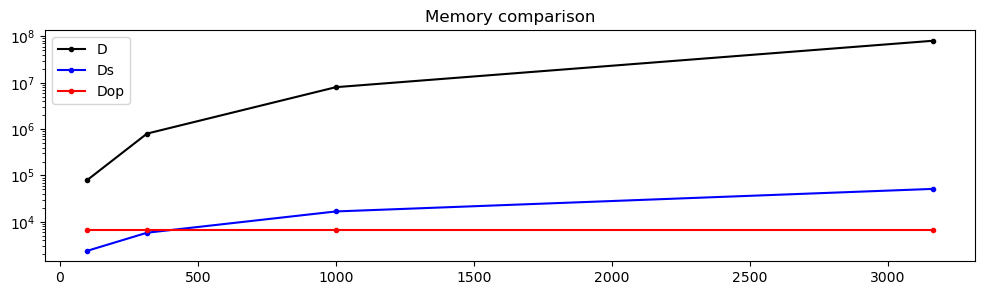

In [21]:
FirstDerivative_memory()

Finally, let's try to move on step further and try to solve the inverse problem. 

最后，让我们尝试更进一步，尝试解决逆问题。

For the dense matrix, we will use `scipy.linalg.lstsq`. For operator PyLops this can be very easily done by using the '/' which will call `scipy.sparse.linalg.lsqr` solver (you can also use this solver directly if you want to fine tune some of its input parameters.

对于稠密矩阵，我们将使用 `scipy.linalg.lstsq`。对于算子 PyLops，这可以通过使用 '/' 非常容易地完成，这将调用 `scipy.sparse.linalg.lsqr` 求解器（如果您想微调其某些输入参数，也可以直接使用此求解器）。

In [22]:
xinv = lstsq(D, y)[0]  # type: ignore
print('xinv: ', xinv)

xinv = Dop / y
print('xinv: ', xinv)

xinv:  [-5.00000000e+00 -4.00000000e+00 -3.00000000e+00 -2.00000000e+00
 -1.00000000e+00 -1.38788231e-15  1.00000000e+00  2.00000000e+00
  3.00000000e+00  4.00000000e+00  5.00000000e+00]
xinv:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In both cases we have retrieved the correct solution!

在这两种情况下，我们都检索到了正确的解！

## Chaining operators 链接算子

Up until now, we have discussed how brand new operators can be created in few systematic steps. This sounds cool, but it may look like we would need to do this every time we need to solve a new problem.

到目前为止，我们已经讨论了如何通过几个系统性的步骤创建全新的算子。这听起来很酷，但看起来好像我们每次需要解决新问题时都需要这样做。

This is where **PyLops** comes in. Alongside providing users with an extensive collection of operators, the library allows such operators to be combined via basic algebraic operations (eg summed, subtracted, multiplied) or chained together (vertical and horizontal stacking, block and block diagonal).

这就是 **PyLops** 的用武之地。除了为用户提供广泛的算子集合外，该库还允许通过基本代数运算（例如加、减、乘）组合此类算子，或将它们链接在一起（垂直和水平堆叠、块和块对角）。

We will see more of this in the following. For now let's imagine to have a modelling operator that is a smooth first-order derivative. To do so we can chain the ``FirstDerivative`` operator ($\mathbf{D}$) that we have just created with a smoothing operator ($\mathbf{S}$)(https://pylops.readthedocs.io/en/latest/api/generated/pylops.Smoothing1D.html#pylops.Smoothing1D) and write the following problem:

我们将在下面看到更多这方面的内容。现在让我们想象有一个建模算子，它是一个平滑的一阶导数。为此，我们可以将我们刚刚创建的 ``FirstDerivative`` 算子 ($\mathbf{D}$) 与平滑算子 ($\mathbf{S}$)(https://pylops.readthedocs.io/en/latest/api/generated/pylops.Smoothing1D.html#pylops.Smoothing1D) 链接起来，并编写以下问题：

$$\mathbf{y} = \mathbf{S} \mathbf{D} \mathbf{x}$$

<img src="figs/smoothder.png" width="800">

Let's create it first and attempt to invert it afterwards.

让我们先创建它，然后尝试反演它。

<51x51 _ProductLinearOperator with dtype=float64>


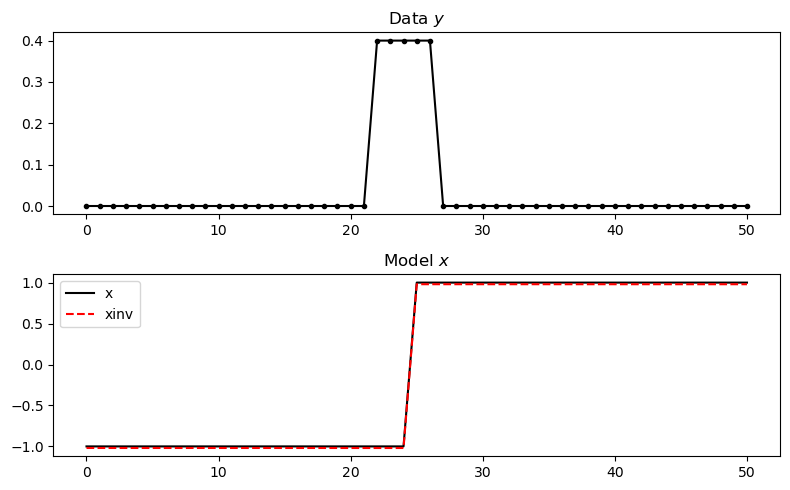

In [ ]:
nx = 51
x = np.ones(nx)
x[:nx//2] = -1

Dop = pylops.FirstDerivative(nx, edge=True, kind='forward')
Sop = pylops.Smoothing1D(5, nx)

# Chain the two operators
Op = Sop * Dop
print(Op)

# Create data
y = Op * x  # type: ignore

# Invert
# xinv = Op / y


xinv = normal_equations_inversion(Op, y, [pylops.Identity(nx)], epsRs=[1e-3])[0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
ax1.plot(y, '.-k')
ax1.set_title(r"Data $y$")
ax2.plot(x, 'k', label='x')
ax2.plot(xinv, '--r', label='xinv')
ax2.legend()
ax2.set_title(r"Model $x$")
plt.tight_layout()

## Wavelet estimation 子波估计

Finally, we want to look at something more real. Let's take one of geophysicists' most common task: **well-tie**. As part of the process to tie a well with a seismic data, we are always required to make an estimate of the wavelet in the seismic data. In this example we will be dealing with pre-stack seismic data, and more specifically with an angle gather $d(t, \theta)$ alongside with synthetic well logs of $V_P$, $V_S$, and $\rho$.

最后，我们要看一些更真实的东西。让我们以地球物理学家最常见的任务之一为例：**井震标定**。作为将井与地震数据绑定的过程的一部分，我们总是需要对地震数据中的子波进行估计。在这个例子中，我们将处理叠前地震数据，更具体地说是角度道集 $d(t, \theta)$ 以及 $V_P$、$V_S$ 和 $\rho$ 的合成测井曲线。

This problem can be written in mathematical form as:

这个问题可以用数学形式写成：

$$
d(t, \theta) =  \sum_{i=1}^N G_i(t, \theta) m_i(t) * w(t)
$$

where $m_i(t) \; i=1,2,3$ is the model vector containing the natural logarithm of the three different logs, $G_i(t, \theta) \; i=1,2,3$ are the AVO coefficients of e.g., Aki-Richards equation, and $w(t)$ is the time domain seismic wavelet we wish to estimate. In compact form we write:

其中 $m_i(t) \; i=1,2,3$ 是包含三个不同测井曲线自然对数的模型向量，$G_i(t, \theta) \; i=1,2,3$ 是例如 Aki-Richards 方程的 AVO 系数，$w(t)$ 是我们希望估计的时域地震子波。以紧凑形式我们写成：

$$
\mathbf{d}=  \mathbf{G} \mathbf{w}
$$

where $\mathbf{G}$ is the operator that convolves an angle-variant reflectivity series
with the wavelet $\mathbf{w}$.

其中 $\mathbf{G}$ 是将随角度变化的反射率序列与子波 $\mathbf{w}$ 进行卷积的算子。

Let's start by creating the input elastic property profiles and wavelet.

让我们从创建输入弹性属性剖面和子波开始。

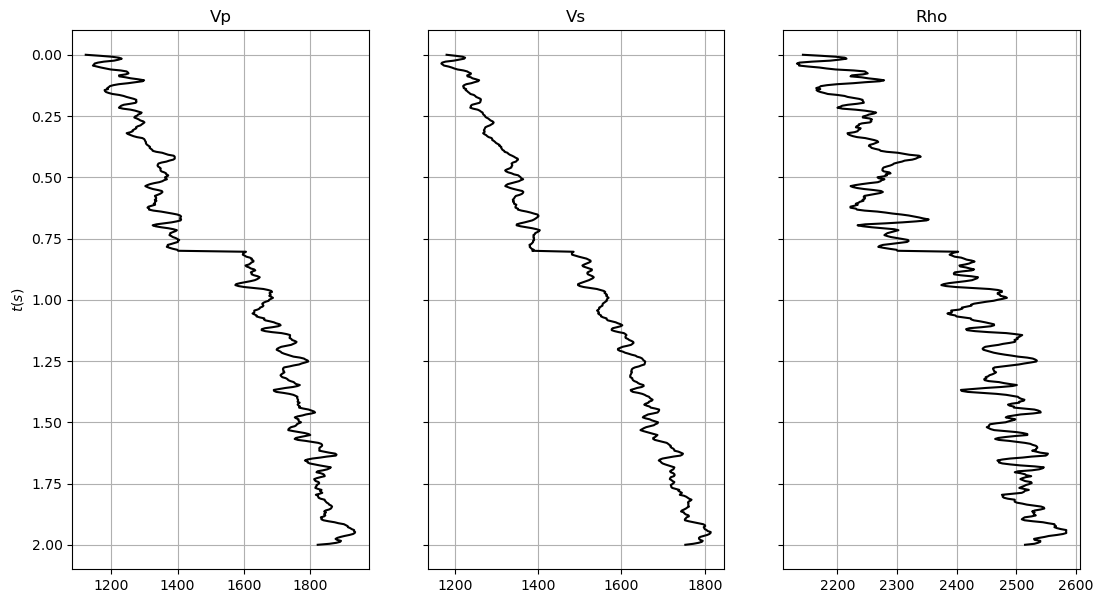

In [ ]:
# Time and angles
nt0 = 501
dt0 = 0.004
ntheta = 21
thetamin, thetamax = 0, 50

t0 = np.arange(nt0)*dt0
theta = np.linspace(thetamin, thetamax, ntheta)

# Elastic property profiles
vp = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5., 1, np.random.normal(0, 80, nt0))
vs = 600 + np.arange(nt0)/2 + vp/2 + filtfilt(np.ones(5)/5., 1, np.random.normal(0, 20, nt0))
rho = 1000 - np.arange(nt0)/2 + vp + filtfilt(np.ones(5)/5., 1, np.random.normal(0, 30, nt0))
vp[201:] += 200
vs[201:] += 100
rho[201:] += 100

# Wavelet (both zero-phase and with delay)
ntwav = 101
wavoff = 10
wav, twav, wavc = ricker(t0[:ntwav//2+1], 5)
wav_phase = np.hstack((wav[wavoff:], np.zeros(wavoff)))  # type: ignore

fig, axs = plt.subplots(1, 3, figsize=(13, 7), sharey=True)
axs[0].plot(vp, t0, 'k')
axs[0].set_title('Vp')
axs[0].set_ylabel(r'$t(s)$')
axs[0].invert_yaxis()
axs[0].grid()
axs[1].plot(vs, t0, 'k')
axs[1].set_title('Vs')
axs[1].invert_yaxis()
axs[1].grid()
axs[2].plot(rho, t0, 'k')
axs[2].set_title('Rho')
axs[2].invert_yaxis()
axs[2].grid()

At this point we combine the three well logs into a unique vector $\mathbf{m}$.

此时，我们将三个测井曲线组合成一个唯一的向量 $\mathbf{m}$。

In [25]:
# vs/vp profile
vsvp = 0.5
vsvp_z = np.linspace(0.4, 0.6, nt0)

# Model
m = np.stack((np.log(vp), np.log(vs), np.log(rho)), axis=1)

We can now create the operators to model a synthetic pre-stack seismic gather with a zero-phase wavelet.

我们现在可以创建算子来模拟具有零相位子波的合成叠前地震道集。

In [26]:
Wavesop = \
    pylops.avo.prestack.PrestackWaveletModelling(m, theta, nwav=ntwav, wavc=wavc,
                                                 vsvp=vsvp, linearization='akirich')

c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\pylops\utils\signalprocessing.py:49: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


We then apply those operators to the elastic model and create our synthetic seismic pre-stack data.

然后我们将这些算子应用于弹性模型并创建我们的合成地震叠前数据。

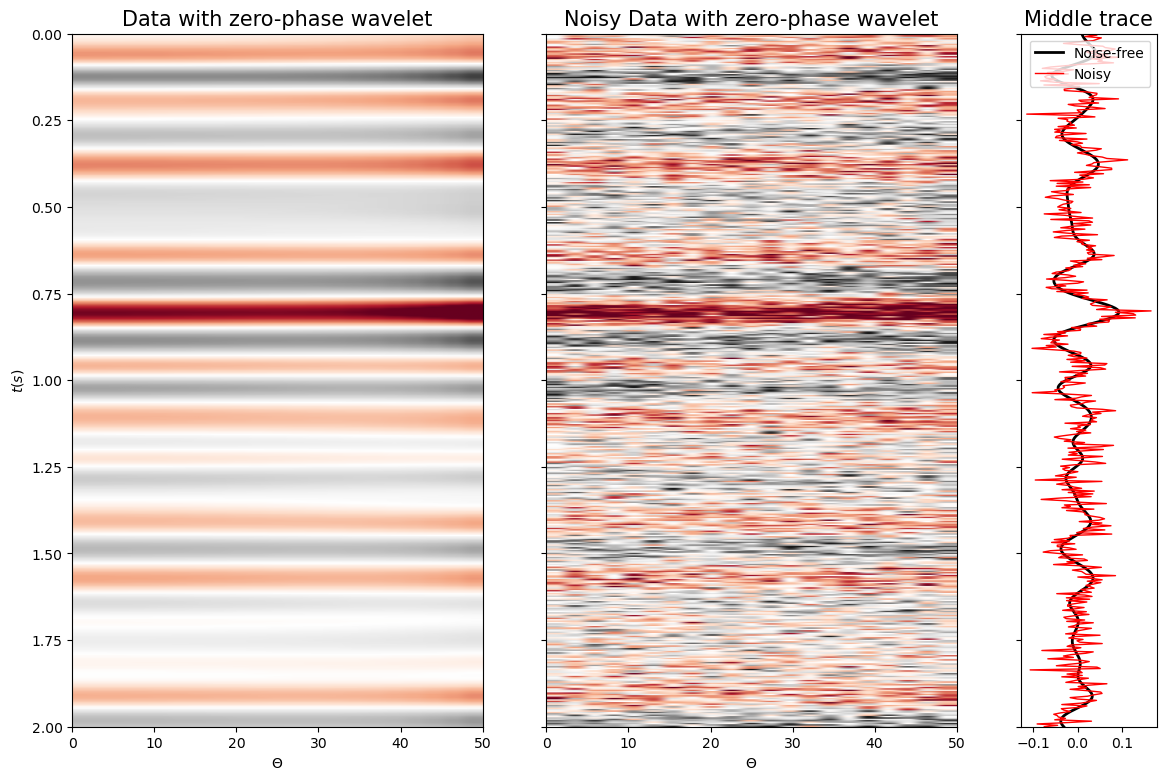

In [27]:
# Data
d = (Wavesop * wav).reshape(ntheta, nt0).T  # type: ignore

# Add noise
dn = d + np.random.normal(0, 3e-2, d.shape)

fig, axs = plt.subplots(1, 3, figsize=(14, 9), sharey=True, gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0].imshow(d, cmap='RdGy_r', extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[0].axis('tight')
axs[0].set_xlabel(r'$\Theta$')
axs[0].set_ylabel(r'$t(s)$')
axs[0].set_title('Data with zero-phase wavelet', fontsize=15)
axs[1].imshow(dn, cmap='RdGy_r', extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[1].set_title('Noisy Data with zero-phase wavelet', fontsize=15)
axs[1].set_xlabel(r'$\Theta$');
axs[1].axis('tight')
axs[2].plot(d[:, ntheta//2], t0, 'k', lw=2, label='Noise-free')
axs[2].plot(dn[:, ntheta//2], t0, 'r', lw=1, label='Noisy')
axs[2].set_title('Middle trace', fontsize=15)
axs[2].legend();

We are finally ready invert the data and make an estimate of our wavelet. First we will consider noise-free data (inverse crime).

我们终于准备好反演数据并对我们的子波进行估计。首先我们将考虑无噪声数据（反演犯罪）。

Subsequently we use the data to which we have added some random noise. Here, we need to add a [**regularization**](https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.RegularizedInversion.html) term in the inversion process to obtain a well-behaved wavelet also under noise conditions.

随后我们使用添加了一些随机噪声的数据。在这里，我们需要在反演过程中添加一个 [**正则化**](https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.RegularizedInversion.html) 项，以便在噪声条件下也能获得表现良好的子波。

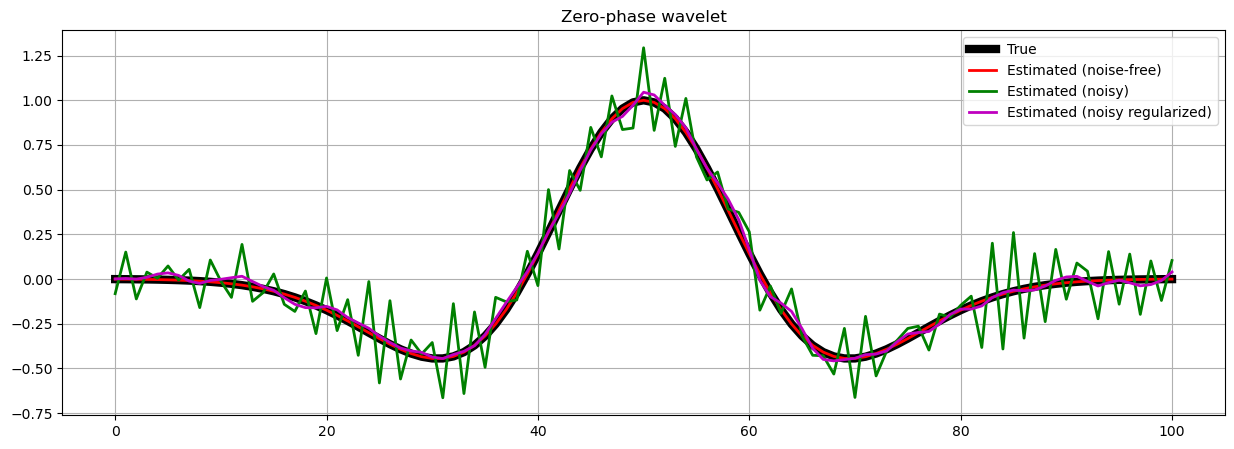

In [30]:
wav_est = Wavesop / d.T.flatten()
wavn_est = Wavesop / dn.T.flatten()

# Create regularization operator
D2op = pylops.SecondDerivative(ntwav)

# Invert for wavelet
wavn_reg_est, istop, itn, r1norm, r2norm = \
    regularized_inversion(Wavesop, dn.T.flatten(), [D2op],
                          epsRs=[np.sqrt(0.1)],
                          **dict(damp=np.sqrt(1e-4),
                                 iter_lim=200, show=0))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 5))
ax.plot(wav, 'k', lw=6, label='True')
ax.plot(wav_est, 'r', lw=2, label='Estimated (noise-free)')
ax.plot(wavn_est, 'g', lw=2, label='Estimated (noisy)')
ax.plot(wavn_reg_est, 'm', lw=2, label='Estimated (noisy regularized)')
ax.set_title('Zero-phase wavelet')
ax.grid()
ax.legend(loc='upper right')
ax.axis('tight');

Finally we repeat the same exercise, but this time we use a [**preconditioner**](https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.PreconditionedInversion.html).

最后我们重复同样的练习，但这次我们使用一个 [**预条件器**](https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.PreconditionedInversion.html)。

Initially, our preconditioner is a `pylops.Symmetrize` operator to ensure that our estimated wavelet is zero-phase. After we chain the `pylops.Symmetrize` and the `pylops.Smoothing1D` operators to also guarantee a smooth wavelet.

最初，我们的预条件器是一个 `pylops.Symmetrize` 算子，以确保我们估计的子波是零相位的。之后我们将 `pylops.Symmetrize` 和 `pylops.Smoothing1D` 算子链接起来，以同时保证子波平滑。

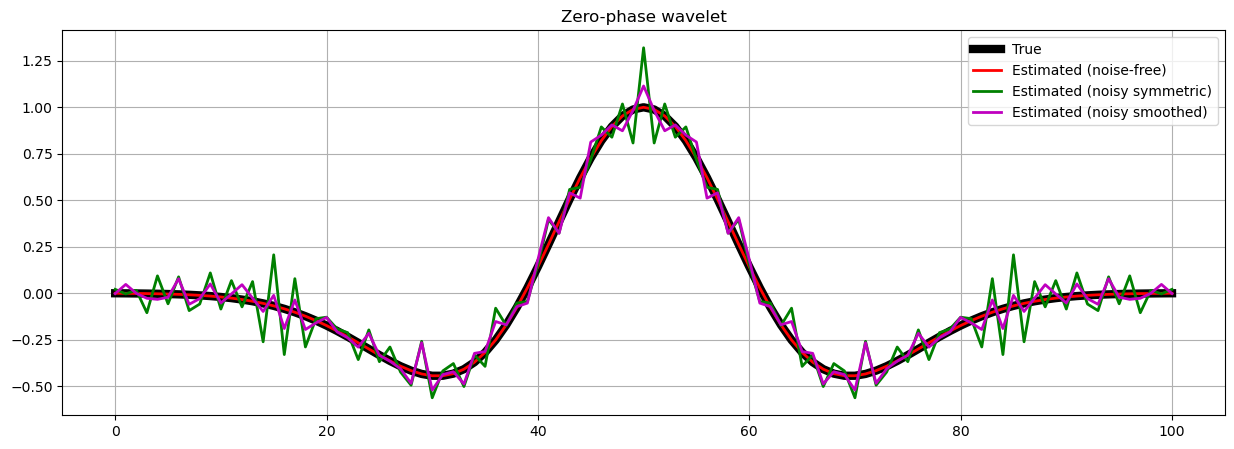

In [32]:
# Create symmetrize operator
Sop = pylops.Symmetrize((ntwav+1)//2)

# Create smoothing operator
Smop = pylops.Smoothing1D(11, dims=((ntwav+1)//2,))

# Invert for wavelet
wavn_prec_est = \
    preconditioned_inversion(Wavesop, dn.T.flatten(), Sop,
                             **dict(damp=np.sqrt(1e-4),
                                    iter_lim=200,
                                    show=0))[0]

wavn_smooth_est = \
    preconditioned_inversion(Wavesop, dn.T.flatten(), Sop * Smop,
                             **dict(damp=np.sqrt(1e-4),
                                    iter_lim=200,
                                    show=0))[0]

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 5))
ax.plot(wav, 'k', lw=6, label='True')
ax.plot(wav_est, 'r', lw=2, label='Estimated (noise-free)')
ax.plot(wavn_prec_est, 'g', lw=2, label='Estimated (noisy symmetric)')
ax.plot(wavn_smooth_est, 'm', lw=2, label='Estimated (noisy smoothed)')
ax.set_title('Zero-phase wavelet')
ax.grid()
ax.legend(loc='upper right');

## Recap 回顾

In this first tutorial we have learned to:
在第一个教程中，我们学习了：

- translate a linear operator from pen and paper to computer code.
- write our own linear operators.
- use PyLops linear operators to perform forward, adjoint and inverse.
- combine PyLops linear operators.
- solve regularized and preconditioned inverse problems with PyLops optimization routines.
- 将线性算子从纸笔翻译成计算机代码。
- 编写我们自己的线性算子。
- 使用 PyLops 线性算子执行正演、伴随和反演。
- 组合 PyLops 线性算子。
- 使用 PyLops 优化例程解决正则化和预条件逆问题。

In [ ]:
scooby.Report(core='pylops')  # type: ignore

--------------------------------------------------------------------------------
  Date: Mon Dec 08 02:30:42 2025 UTC

                OS : Windows (10 10.0.19041 SP0 Multiprocessor Free)
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.1 GiB
       Environment : Jupyter

  Python 3.10.19 | packaged by conda-forge | (main, Oct 13 2025, 14:05:01)
  [MSC v.1944 64 bit (AMD64)]

            pylops : 2.6.0
             numpy : 2.2.6
             scipy : 1.15.3
           IPython : 8.37.0
        matplotlib : 3.10.6
            scooby : 0.10.2
--------------------------------------------------------------------------------